---
# Calculate words per minute for rap, rock, and country songs
---

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image, display
import nltk
from nltk.classify import apply_features
from nltk import word_tokenize
from collections import Counter
import random
import time
import re
from datetime import datetime
from string import punctuation
fs = 16 # fontsize

## Load and format the lyrics JSON object

In [2]:
artists_rap = json.load(open('lyrics/rap_lyrics.json'))

In [3]:
artists_rock = json.load(open('lyrics/rock_lyrics.json'))

In [4]:
artists_country = json.load(open('lyrics/country_lyrics.json'))

In [5]:
# artists_raw = artists_rap + artists_rock + artists_country
artists_raw = artists_rap

In [22]:
def result_is_lyrics(song_title):
    """Returns False if result from Genius is not actually song lyrics"""
    regex = re.compile(
        r"(tracklist)|(track list)|(album art(work)?)|(liner notes)|(booklet)|(credits)", re.IGNORECASE)
    return not regex.search(song_title)

In [6]:
# Determine
def getArtistImage(songs):    
    urls = [None]
    for song in songs:
        if song['raw']['album'] is not None:
            try:                
                urls.append(song['raw']['album']['artist']['image_url'])                
            except:
                pass
    
    return Counter(urls).most_common()[0][0] # Most common image

# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 10, 2500
artists = list(filterBySongCount(artists_raw, min_songs, max_songs))

# Artist images
for artist in artists:
    artist['image_url'] = getArtistImage(artist['songs'])
    
    # Kludge
    if artist['artist'] == 'Black Thought':
        artist['image_url'] = 'https://images.genius.com/23de511f4ac50d900128ea363b7d81b3.450x320x1.jpg'
    if artist['artist'] == 'André 3000':
        artist['image_url'] = 'http://images.genius.com/64b15c9489c65f5bf8f6577334347404.434x434x1.jpg'            
        
# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs, genres = [], []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        if len(song['lyrics'].split(' ')) > 10:
            all_songs.append(song)
            if song['genre'] not in genres:
                genres.append(song['genre'])
              
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 132 artists, with a minimum of 10 songs per artist.
Female: 41, male: 91
Database contains 24754 songs.


In [7]:
for artist in artists[:3]:
    print(artist['artist'])
    display(Image(url=artist['image_url'], width=100))

2Pac


Eminem


The Notorious B.I.G.


---
# Words per minute

In [221]:
# Load the Spotify data
spotify_data = json.load(open('./spotify_data_v20.json'))

In [222]:
# Song durations
all_spotify_songs = []
for artist in spotify_data:
    for song in artist['songs']:
        duration = song['spotify']['duration_ms']/1000
        if duration is not None:
            song['duration'] = duration
            all_spotify_songs.append(song)

### Calculate word counts

In [160]:
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

In [223]:
# Calculate word counts, words per minute, and lexical diversity
unique = False
m = 600 if unique else 800
word_counts, wpm, lexdivs = [],[],[]
songs_with_wc = []
for song in all_spotify_songs:
    
    if 'instrumental' not in song['title'].lower():
        lyrics = clean_str(song['lyrics'])   

        # Count the words in the song's lyrics
        words = list(filter(lambda x: x!="", clean_str(lyrics.replace('\n',' ')).split(' ')))

        if len(words) < m and len(words) > 10 and song['duration'] > 10: # Get rid of outliers
            # Word counts (unique or total)
            wc = len(set(words)) if unique else len(words)
            word_counts.append(wc)

            # Lexical diversity
            if wc > 0:
                lexdivs.append(len((set(words)))/len(words))            

            # Calculate words per minute for each song            
            wpm.append(word_counts[-1]/song['duration']*60)

            # New list of just songs with a word count
            songs_with_wc.append(song)

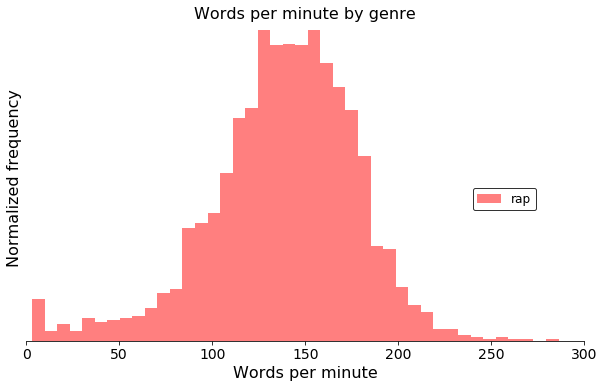

In [227]:
# Options for the plot
norm = True

# Plot the histogram of words per minute
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(wpm, 150, color=c, alpha=0.5, label=g, normed=norm)

# Touch up the plot
FS = 16
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0, 300])
if unique:
    ax.set_xlabel("Unique words per minute", fontsize=FS)
    title = "Unique words per minute by genre"
else:
    ax.set_xlabel("Words per minute", fontsize=FS)    
    title = "Words per minute by genre"        
if norm:
    ax.set_ylabel("Normalized frequency", fontsize=FS)
    ax.get_yaxis().set_ticks([])
    ax.spines['left'].set_visible(False)
else:    
    ax.set_ylabel("Number of songs", fontsize=FS)    
ax.text(0.5, 1, title, fontsize=FS,
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
ax.legend(loc=(0.8,0.4), edgecolor='k', fontsize=FS-4)

plt.show()

---
# Release date data

In [229]:
songs_with_year = []
for song in songs_with_wc:
    date = song['spotify']['album']['release_date']
    if len(date) == 4:
        d = datetime.strptime(date, '%Y')
    else:
        d = datetime.strptime(date, '%Y-%M-%d')
    if (d.year>=1900 and d.year<=2018): # kludge for correct parsing of date
        song['date'] = d
        songs_with_year.append(song)

print("{:.1f}% of songs have date information, for a total of {} songs.".format(100*len(songs_with_year)/len(songs_with_wc),len(songs_with_year)))

100.0% of songs have date information, for a total of 2162 songs.


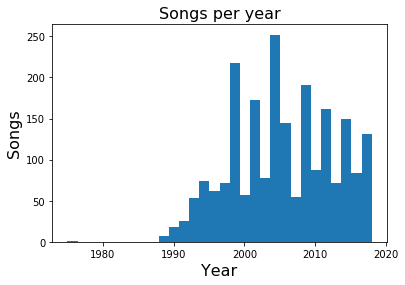

In [233]:
# Kludge to sort the songs by year
years = np.array(list(map(lambda d: d.year, [s['date'] for s in songs_with_year])))
songs_with_year = np.array([x for _, x in sorted(zip(years, songs_with_year), key=lambda pair: pair[0])])
years.sort()

# Distribution of the years
plt.hist(years, 30)
plt.xlabel("Year", fontsize=FS)
plt.ylabel("Songs", fontsize=FS)
plt.title("Songs per year",fontsize=FS)
plt.show()

## Words per minute over time

In [242]:
def fitLine(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    soln = np.linalg.lstsq(A, y, rcond=None)[0]    
    
    # residual sum of squares
    y_fit = soln[0]*x + soln[1]
    ss_res = np.sum((y - y_fit)**2) # residuals ?
    ss_tot = np.sum((y - y.mean())**2) # total sum of squares
    r2 = round(1 - (ss_res / ss_tot), 3) # r-squared
        
    return y_fit, x, r2

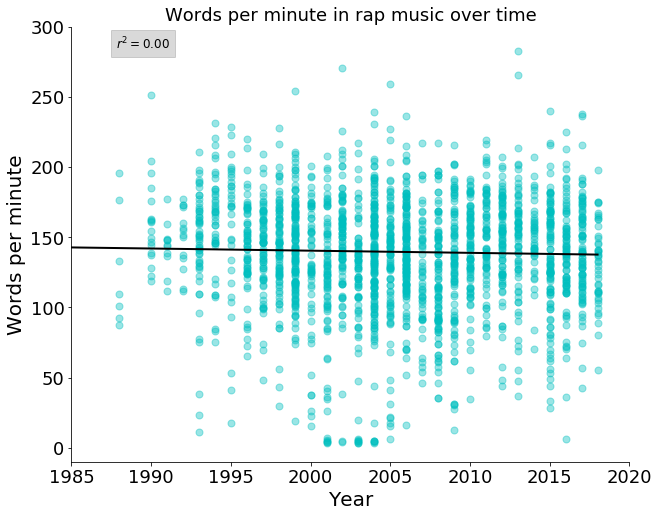

In [256]:
# http://kaylinwalker.com/50-years-of-pop-music/

# Plot the data
fig, ax = plt.subplots(figsize=(10,8))
y_fit, t, r2 = fitLine(years, np.array(wpm))
ax.plot(years, wpm, 'co', alpha=0.4, markersize=7)
ax.plot(t, y_fit, 'k', linewidth=2)

# Touch up the plot

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.annotate(r'$r^2={:0.2f}$'.format(r2), style='italic', fontsize=FS-4,
    bbox={'facecolor':'black', 'alpha':0.15, 'pad':5}, xycoords='axes fraction', xy=(0.08, 0.95)),        
ax.set_xlim([1985, 2020])
ax.set_ylim([-10, 300])
ax.set_title("Words per minute in rap music over time", fontsize=FS+2)
ax.set_xlabel("Year", fontsize=FS+4)
ax.set_ylabel("Words per minute", fontsize=FS+4)
ax.tick_params(labelsize=FS+2, labelcolor='k', color='k')
    
# plt.savefig('./figures/TimePlot_words_per_song.png', bbox_inches='tight', dpi=300)
plt.show()